## Graduate Student Project
This is build upon the final case study project and can clip the Jackson county as area of interest.
Therefore, one clipping cell is added to the project for Graduate Student Project. 

# Agricultural Fields in Ramsey county in Minnesota

### Delineating agricultural field boundaries from Sentinel-2 imagery. 

The case study is about extracting polygons of agricultural fields from a Sentinel-2 satellite imagery of a small-scale study area in Ramsey county in Minnesota. 

**This code is an updated version of Jesse Bakker's code.**

# Creating the Environment in Conda


I manually created the environment with the following commands in Anaconda environment management system:

**Create an empty environment without any packages:**
conda create -n geoenv

**Activate the new environment:** 
conda activate geoenv

**Install all the necessary packages at once so that conda handles the dependencies:** 
conda install -c conda-forge python=3.8.3 gdal=3.0.4 geopandas=0.7.0 rasterio=1.1.5 dask=2.19.0 xarray=0.15.1 matplotlib=3.2.1 seaborn=0.10.1 scikit-learn=0.23.1 scikit-image=0.17.2 ipython=7.15.0 ipykernel=5.3.0 folium=0.11.0 bokeh=2.1.1 holoviews=1.13.3 datashader=0.11.0 psycopg2=2.8.5 sqlalchemy=1.3.17 geoalchemy2=0.6.3 descartes=1.1.0 contextily=1.0.0 memory_profiler=0.57.0 autopep8=1.5.3 netcdf4=1.5.3

### Importing Packages:


In [9]:

# import libraries
import os
import scipy.ndimage as ndi
import numpy as np
import xarray as xr
import glob
import datetime
import zipfile
from osgeo import gdal
from rasterio import features
import fiona
import warnings



Frist I need to point the 'prep_file_dir' parameter in the global_config dictionary to a local directory with zipped .SAFE files from Sentinel-2 or use the sample data.

In [10]:
# set config for the area of interest
config = {
    "prep_file_dir": "/Users/hossa084/Downloads/GEOG5541/project/",
    "prep_tile_id": "TUJ",
    "prep_base_chunk": "auto",
    "prep_time_chunk": "auto",
    "prep_remove_overlap": True,
    "prep_manual_subset": True,
    "prep_x_start": 4200,
    "prep_y_start": 150,
    "prep_step": 1000,
    "prep_cloud_coverage_thresh": 30,
    "prep_load_cloud_mask": False,
    "prep_apply_cloud_mask": False,
    "prep_cloud_mask_thresh": 30,
    "prep_clip_percentile": 1,
    "mask_ndwi_thresh": 0.5,
    "mask_ndvi_max_thresh": 0.5,
    "mask_ndvi_range_thresh": 0,
    "shp_out_dir": "/Users/hossa084/Downloads/GEOG5541/project/Output/",
    "shp_file_out_str": "_MASK_Ramsey_",
}

Then, It clips values above and below a certain percentile of the array and normalizes array values to be passed to processing functions:

In [11]:
def clip_nan(array, percentile):

    np.seterr(divide="ignore", invalid="ignore")
    vmax = np.nanpercentile(array, 100 - percentile)
    vmin = np.nanpercentile(array, percentile)
    #    array_clip = ((array.astype("f8") - vmin) / (vmax - vmin)).astype("f4") # xarray docs suggest this saves memory
    array_clip = np.clip((array), a_min=vmin, a_max=vmax)
    return array_clip


def normalize(array):

    np.seterr(divide="ignore", invalid="ignore")
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

This cell expects a list of zipped sentinel tiles and an epsg code (which needs to be consistent for all tiles) in the format: "EPSG_32614", which can be identified from calling !gdalinfo Returns a dictionary consisisting tile information (metadata).

In [12]:
def xr_get_zip_info_to_dict(zip_file):

    ### Info from file name
    file_name = zip_file[:-4]
    tile_id = zip_file[-26:-20]
    date_str = zip_file[-19:-11]
    date_obj = datetime.datetime.strptime(date_str, "%Y%m%d")
    platform = zip_file[:3]
    prod_level = zip_file[7:10]

    gdal_info = gdal.Info(zip_file, format="json")

    # set GDAL call for 10m bands in zip tile directory
    gdal_str = gdal_info["metadata"]["SUBDATASETS"]["SUBDATASET_1_NAME"]
    epsg = gdal_str[-10:]
    cloud_coverage = float(gdal_info["metadata"][""]["CLOUD_COVERAGE_ASSESSMENT"])
    nodata_pixel_percentage = float(
        gdal_info["metadata"][""]["NODATA_PIXEL_PERCENTAGE"]
    )

    # Get string for cloud mask image
    # Get contents of zip file as a list
    zip_contents = zipfile.ZipFile(zip_file, "r")
    # path to 20m cloud mask within the zipped file
    cld_path = [s for s in zip_contents.namelist() if "MSK_CLDPRB_20m.jp2" in s]
    # create string to call cloud mask .jp2 from zipped file with rasterio
    cld_mask_str = "/vsizip/" + zip_file + "/" + cld_path[0]

    # return dict of tile info with top level key: file name
    info_dict = {
        file_name: {
            "tile_id": tile_id,
            "date_str": date_str,
            "date_obj": date_obj,
            "gdal_str": gdal_str,
            "epsg": epsg,
            "cloud_coverage": cloud_coverage,
            "nodata_pixel_percentage": nodata_pixel_percentage,
            "platform": platform,
            "product_level": prod_level,
            "cloud_mask_str": cld_mask_str,
        }
    }

    return info_dict

The xr_dict_to_dataset_cloud_mask() function also includes parameters for specifying the threshold for cloud coverage
on images being read into the time stack ('prep_cloud_coverage_thresh') and for applying the cloud mask from the 
Sentinel-2 data quality information. This cloud mask raster is 20m resolution, so it must be resampled to 10m to be
applied as a mask to the imagery bands. The 'prep_load_cloud_mask' boolean parameter specifies whether the cloud mask will be
loaded from the imagery data and the 'prep_apply_cloud_mask' boolean parameter specifies whether it will be applied to the 
imagery as a mask.



In [13]:
def xr_dict_to_dataset_cloud_mask(
    da_name,
    gdal_str,
    date_obj,
    tile_id,
    cld_mask_str,
    load_cloud_mask=config["prep_load_cloud_mask"],
    apply_cloud_mask=config["prep_apply_cloud_mask"],
    cloud_mask_thresh=config["prep_cloud_coverage_thresh"],
    chunks=(-1, config["prep_step"], config["prep_step"]),
    remove_overlap=config["prep_remove_overlap"],
    manual_subset=config["prep_manual_subset"],
    x_start=config["prep_x_start"],
    y_start=config["prep_x_start"],
    step=config["prep_step"],
):

    """
    Pass tile information (gdal_str) to open file to xr.dataset and place object in ds_list
    With remove_overlap set to True, the function selects by x,y extent to remove right and bottom overlap with neighboring tiles
    The total pixel overlap in each direction with the right and bottom neighbors is 983 pixels,
    based on the difference in initial coordinates (top left) from the rasterio objects

    parameters:
        da_name - xr DataArray name, needed to load in imagery from info_dict via xr_get_zip_info_to_dict()
        gdal_str - string to read the 10m bands from zipped tile from info_dict via xr_get_zip_info_to_dict()
        date_obj - date of imagery formatted as datetime obj from info_dict via xr_get_zip_info_to_dict()
        tile_id - Sentinel tile ID from info_dict via xr_get_zip_info_to_dict()
        cld_mask_str - path to cloud mask in zipped tile from info_dict via xr_get_zip_info_to_dict()

        load_cloud_mask - Boolean to load the cloud mask raster
        apply_cloud_mask - Boolean to apply cloud mask to RGBN bands
        cloud_mask_thresh - int to set threshold for cloud mask probability

        chunks - (time dim dask chunks, x dim dask chunks, y dim dask chunks) via config
        remove_overlap - Boolean to spatially subset the tile to remove the overlapping area with neighboring tile
        manual_subset - Boolean to assign manual spatial subset, used for manual chunking
        x_start - int to assign first x value, left edge of the subset
        y_start - int to assign first y value, top edge of the subset
        step - int to assign how many pixels in each direction (x, y) of the manual subset

    """
    # Lazily read file to xarray DataArray
    rio_da = xr.open_rasterio(gdal_str, chunks=chunks)
    # set time coordinate
    rio_da["time"] = date_obj
    # set da name
    rio_da.name = da_name
    # set tile_id
    rio_da.attrs["tile_id"] = tile_id

    if load_cloud_mask:

        # Get cloud mask
        cld_mask_da = xr.open_rasterio(cld_mask_str)
        cld_mask_da["time"] = date_obj
        cld_mask_da.name = "cloud_mask"

        # Resample cloud mask to 10m resolution to work with imagery bands
        new_x = np.linspace(
            (cld_mask_da.x[0].values - 5).astype(int),
            (cld_mask_da.x[-1].values + 5).astype(int),
            len(cld_mask_da.x) * 2,
        )
        new_y = np.linspace(
            (cld_mask_da.y[0].values + 5).astype(int),
            (cld_mask_da.y[-1].values - 5).astype(int),
            len(cld_mask_da.y) * 2,
        )
        cld_mask_da_interp = cld_mask_da.interp(x=new_x, method="nearest")
        cld_mask_da_interp = cld_mask_da_interp.interp(y=new_y, method="nearest")
        base_chunk = chunks[1]
        ### Prep cloud mask data to join with imagery bands
        cld_mask_da_interp = cld_mask_da_interp[0, :, :]
        cld_mask_da_interp = cld_mask_da_interp.chunk(chunks=(base_chunk, base_chunk))
        del cld_mask_da_interp.attrs["transform"]
        del cld_mask_da_interp.attrs["res"]
        del cld_mask_da_interp.attrs["is_tiled"]
        del cld_mask_da_interp.attrs["nodatavals"]
        del cld_mask_da_interp.attrs["scales"]
        del cld_mask_da_interp.attrs["offsets"]
        cld_mask_da_interp = cld_mask_da_interp.drop("band")

    # this removes the area overlapping with the neighboring tile on the right and bottom
    # The overlap is 983 pixels, but using 980 results in a clean 10000 by 10000 pixel tile
    if remove_overlap:
        rio_da = rio_da[:, :-980, :-980]
        if load_cloud_mask:
            cld_mask_da_interp = cld_mask_da_interp[:-980, :-980]

    if manual_subset:
        # Just for processing in manual batches
        x = x_start
        y = y_start
        x_end = x + step
        y_end = y + step
        rio_da = rio_da[:, x:x_end, y:y_end]
        if load_cloud_mask:
            cld_mask_da_interp = cld_mask_da_interp[x:x_end, y:y_end]

    # convert to dataset
    ds = rio_da.to_dataset(dim="band")
    ds = ds.rename_vars({1: "red", 2: "green", 3: "blue", 4: "nir"})

    # Apply cloud mask to bands
    if apply_cloud_mask:
        ds["cloud_mask"] = cld_mask_da_interp.astype(int)
        ds["red"] = ds["red"].where(ds.cloud_mask < cloud_mask_thresh)
        ds["green"] = ds["green"].where(ds.cloud_mask < cloud_mask_thresh)
        ds["blue"] = ds["blue"].where(ds.cloud_mask < cloud_mask_thresh)
        ds["nir"] = ds["nir"].where(ds.cloud_mask < cloud_mask_thresh)

    return ds

The following function gets parameters like 'tile_id' and 'prep_data_dir' and others to access the zipped sentinel 2 files downloaded from https://scihub.copernicus.eu/dhus/#/home
prep_data applies preprocessing steps to the raw data and returns a xarray dataset holding all xarray data arrays that have passed the cloud coverage condition named ds_time_stack.


In [14]:
def prep_data():

    # set variables from global config
    global config
    # file dir
    file_dir = config["prep_file_dir"]
    tile_id = config["prep_tile_id"]
    # chunking
    base_chunk = config["prep_base_chunk"]  # auto
    time_chunk = config["prep_time_chunk"]  # auto
    chunk_size = (time_chunk, base_chunk, base_chunk)
    rechunk_size = {"time": time_chunk, "x": base_chunk, "y": base_chunk}
    # data read parameters
    cloud_coverage_thresh = config["prep_cloud_coverage_thresh"]
    load_cloud_mask = config["prep_load_cloud_mask"]
    apply_cloud_mask = config["prep_apply_cloud_mask"]
    cloud_mask_thresh = config["prep_cloud_mask_thresh"]
    overlap_bool = config["prep_remove_overlap"]
    manual_subset = config["prep_manual_subset"]
    x_start = config["prep_x_start"]
    y_start = config["prep_y_start"]
    step = config["prep_step"]
    percentile = config["prep_clip_percentile"]

    # set working directory to the folder with the sentinel data tiles
    # Set file_dir in the global variables at top of the code
    os.chdir(file_dir)

    # the tile_id for the specific study area is "JKH"
    glob_str = "*" + tile_id + "*.zip"
    zip_list = glob.glob(glob_str)

    # build dictionary of metadata from gdal_info calls for each tile in the list of zip_files
    tile_info_dict = {}

    for zip_str in zip_list:
        tile_info_dict.update(xr_get_zip_info_to_dict(zip_str))

    # date list to hold date objects of time slices in the data stack in order to avoid duplicate dates
    date_list = []
    count_cloud_pass = 0
    count_total_files = 0
    print("Cloud Coverage Threshold:", cloud_coverage_thresh)
    for k, v in tile_info_dict.items():

        if v["cloud_coverage"] < cloud_coverage_thresh:

            # Print tile info
            print(
                "passed cloud coverage:",
                v["date_str"][:4],
                v["date_str"][4:6],
                v["date_str"][6:],
                "with",
                v["cloud_coverage"],
                "pct | nodata pixel pct:",
                v["nodata_pixel_percentage"],
            )
            # if this is the first tile to pass the cloud coverage thresh, define it as ds_time_stack
            if count_cloud_pass == 0:
                global ds_time_stack
                ds_time_stack = xr_dict_to_dataset_cloud_mask(
                    k,
                    v["gdal_str"],
                    v["date_obj"],
                    v["tile_id"],
                    v["cloud_mask_str"],
                    load_cloud_mask=load_cloud_mask,
                    apply_cloud_mask=apply_cloud_mask,
                    cloud_mask_thresh=cloud_mask_thresh,
                    chunks=chunk_size,
                    remove_overlap=overlap_bool,
                    manual_subset=manual_subset,
                    x_start=x_start,
                    y_start=y_start,
                    step=step,
                )

                date_list.append(v["date_obj"])

            # if not the first tile
            if count_cloud_pass > 0:
                # if a tile with the same date is already in the ds_time_stack, then skip this tile because there can't be two tiles with the same time dim
                if v["date_obj"] in date_list:
                    continue
                ds_time_stack = xr.concat(
                    [
                        ds_time_stack,
                        xr_dict_to_dataset_cloud_mask(
                            k,
                            v["gdal_str"],
                            v["date_obj"],
                            v["tile_id"],
                            v["cloud_mask_str"],
                            load_cloud_mask=load_cloud_mask,
                            apply_cloud_mask=apply_cloud_mask,
                            cloud_mask_thresh=cloud_mask_thresh,
                            chunks=chunk_size,
                            remove_overlap=overlap_bool,
                            manual_subset=manual_subset,
                            x_start=x_start,
                            y_start=y_start,
                            step=step,
                        ),
                    ],
                    dim="time",
                )
                date_list.append(v["date_obj"])
            # Add to the count so that subsequent tiles are concatenated with ds_time_stack instead of overwriting it
            count_cloud_pass += 1

        else:
            print(
                "FAILED cloud coverage:",
                v["date_str"][:4],
                v["date_str"][4:6],
                v["date_str"][6:],
                "with ",
                v["cloud_coverage"],
                "pct | nodata pixel pct:",
                v["nodata_pixel_percentage"],
            )
        count_total_files += 1

    print(
        count_cloud_pass,
        "out of",
        count_total_files,
        "time steps passed cloud coverage threshold",
    )
    if count_cloud_pass == 0:
        print("no tiles below cloud threshold")

    # Rechunk the full dataset and sort by time dimension
    ds_time_stack = ds_time_stack.chunk(chunks=rechunk_size).sortby("time")

    # Clip each band in each of the time steps to remove outliers
    # Clip outlier values in each band
    ds_time_stack = ds_time_stack.map(clip_nan, percentile=percentile, keep_attrs=True)

    # Normalize each band
    ds_time_stack = xr.Dataset.chunk(
        ds_time_stack.map(normalize, keep_attrs=True), chunks=rechunk_size
    )

    print("ds_time_stack", ds_time_stack)
    return ds_time_stack

### Calculate image indices:
NDVI , NDWI

In [15]:
def ndvi_xr(input_ds):
    """
    computes the Normalized Difference Vegetation Index (NDVI)
    """
    np.seterr(divide="ignore", invalid="ignore")
    return (input_ds.nir - input_ds.red) / (input_ds.nir + input_ds.red)


def mask_ndvi_max_and_range(monthly_avg_ndvi_ds, max_thresh=0.3, range_thresh=0.3):
    """
    creates a mask with a logical "or" operation
    """
    return xr.ufuncs.logical_or(
        xr.where(
            monthly_avg_ndvi_ds.max(dim="time", skipna=True)
            - monthly_avg_ndvi_ds.isel(time=0)
            < range_thresh,
            1,
            0,
        ),
        xr.where(monthly_avg_ndvi_ds.max(dim="time", skipna=True) < max_thresh, 1, 0),
    )



def ndwi_xr(input_ds):
    """
    computes the Normalized Difference Water Index (NDWI)
    """
    np.seterr(divide="ignore", invalid="ignore")
    return (input_ds.green - input_ds.nir) / (input_ds.green + input_ds.nir)

def ndvi_2(input_ds):
    """
    computes the Normalized Difference Vegetation Index 2 (NDVI2)
    """
#     (b12-nir)/(b12+nir)
    np.seterr(divide="ignore", invalid="ignore")
    return (input_ds.green - input_ds.nir) / (input_ds.green + input_ds.nir)


def fill_holes(input_array):
    """
    Fills the holes in the inputting binary array. A zero surrounded by ones is gonna be converted to one.
    This will get passed to dask arrays within the dataset through dask.map_overlap() for parallelization
    """
    return ndi.binary_fill_holes(input_array)


def min_filter(input_array, size=(2, 2)):
    """
    calculates a multidimensional minimum filter and returns an array passed the minimum filter with the same shape as input.
    parameter size is the passing footprint which is equivalent to np.ones((2,2)).
    This will get passed to dask arrays within the dataset through dask.map_overlap() for parallelization
    """
    return ndi.minimum_filter(input_array, size=size)



### Threshoulding method: 
Run mask Processing functions.

In [16]:
def mask_processing(input_ds):
    """
    This step is actually the main step in this project.
    This function creates a final binary mask that has the final field pixels as 1 and the non-field pixels as 0.
    The function receives a time serie of xarray data arrays as an xarray dataset and measures the spectral (vegetation) indices and masks out pixels that meet the threshold conditions set in the config dictionary.

    """
    print("-------Mask Processing-------")
    global config
    base_chunk = config["prep_base_chunk"]  # auto
    ndwi_thresh = config["mask_ndwi_thresh"]  # 0.5
    ndvi_max_thresh = config["mask_ndvi_max_thresh"]  
    ndvi_range_thresh = config["mask_ndvi_range_thresh"] 

    ### NDWI mask: mean NDWI across all time steps, masked for values greater than ndwi_thresh
    mask = xr.where(
        ndwi_xr(input_ds).mean(dim="time", skipna=True) > ndwi_thresh, 1, 0
    )  # if true 1, otherwise 0.
    
    

    ### NDVI Masking
    ### combining NDVI mask with NDWI mask via logic or operation
    mask = xr.ufuncs.logical_or(
        mask,
        mask_ndvi_max_and_range(
            ndvi_xr(input_ds.resample(time="1MS").mean(skipna=True)),
            max_thresh=ndvi_max_thresh,
            range_thresh=ndvi_range_thresh,
        ),
    )

    # Invert mask
    mask = xr.where(mask == 1, 0, 1)

    ### Fill holes in the mask so that there aren't stray pixels
    mask = mask.data.map_overlap(fill_holes, depth=1)

    ### Set minimum filter to enforce minimum height/width of background.
    ### This eliminates small isolated areas and expands road areas.
    mask = mask.map_overlap(min_filter, depth=1)

    mask = xr.DataArray(
        mask,
        dims=("y", "x"),
        coords=[input_ds["red"].coords["y"], input_ds["red"].coords["x"]],
    ).chunk({"x": base_chunk, "y": base_chunk})

    return mask


Start running the functions on the area of interest:

In [17]:
### Prep data
ds_time_stack = prep_data()

Cloud Coverage Threshold: 30
passed cloud coverage: 2020 08 22 with 0.103364 pct | nodata pixel pct: 0.0
passed cloud coverage: 2020 07 18 with 0.278476 pct | nodata pixel pct: 1e-05
2 out of 2 time steps passed cloud coverage threshold
ds_time_stack <xarray.Dataset>
Dimensions:  (time: 2, x: 1000, y: 1000)
Coordinates:
  * y        (y) float64 4.858e+06 4.858e+06 4.858e+06 ... 4.848e+06 4.848e+06
  * x        (x) float64 3.015e+05 3.015e+05 3.015e+05 ... 3.115e+05 3.115e+05
  * time     (time) datetime64[ns] 2020-07-18 2020-08-22
Data variables:
    red      (time, y, x) float64 dask.array<chunksize=(2, 1000, 1000), meta=np.ndarray>
    green    (time, y, x) float64 dask.array<chunksize=(2, 1000, 1000), meta=np.ndarray>
    blue     (time, y, x) float64 dask.array<chunksize=(2, 1000, 1000), meta=np.ndarray>
    nir      (time, y, x) float64 dask.array<chunksize=(2, 1000, 1000), meta=np.ndarray>
Attributes:
    transform:     (10.0, 0.0, 300000.0, 0.0, -10.0, 4900020.0)
    crs:       

Run the mask processing and plotting the mask showing agricultural fields:

-------Mask Processing-------


C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\xarray\core\common.py:1105: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache

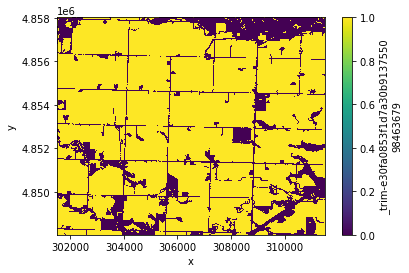

In [19]:
mask = mask_processing(ds_time_stack)

### Writing the created dataArray to shapefile
mask.plot()

In [27]:
# NORMALIZED DIFFERENCE VEGETATION INDEX (NDVI)
# NDVI = (NIR – Red) / (NIR + Red )
# Calculate NDVI dataset
input_ds = ds_time_stack
    
np.seterr(divide="ignore", invalid="ignore")

NDVI = (input_ds.nir - input_ds.red) / (input_ds.nir + input_ds.red)

# Calculate std and var of NDVI over time as new dataArrays
NDVI_std = NDVI.std(dim="time", skipna = False)
NDVI_std = NDVI_std.fillna(0)
NDVI_var = NDVI.var(dim="time", skipna=True)

C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


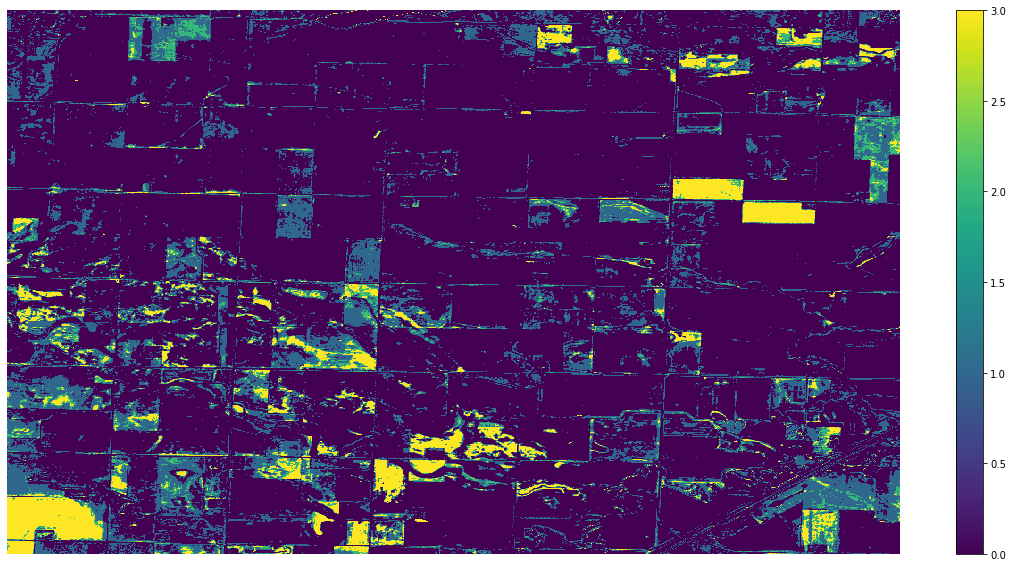

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# class_bins = [0.2, 0.4, 0.6, 0.8]
class_bins = [0.2, 0.4, 0.5]

#0-0.2 -> 0
#0.8-1->4

#-np.inf

norm_NDVI_std = normalize(NDVI_std)

reclass_NDVI = xr.apply_ufunc(np.digitize, norm_NDVI_std, class_bins, dask = 'allowed')
f, ax = plt.subplots(figsize=(20, 10))

im_NDVI = reclass_NDVI.plot.imshow()
ax.set_axis_off()
# x > 0.5
mask3 = xr.where(reclass_NDVI==3, 1, 0)
# 0.4 < x < 0.5
mask2 = xr.where(reclass_NDVI==2, 1, 0)
# 0.2 < x < 0.4
mask1 = xr.where(reclass_NDVI==1, 1, 0)


### Clipping the Jackson county:
This is the cell added for Graduate Student Project. 

<ipython-input-152-70604ec4f13e>:8: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  pol = cn_area.next()


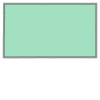

In [152]:
import fiona
import rioxarray as rx
import shapely.vectorized
from shapely.geometry import shape

# store clipping geometry for Ramsey county
fname = r'Ramsey.shp'
cn_area = fiona.open(fname)
pol = cn_area.next()
geom = pol['geometry']
geom_Ramsey = shape(pol['geometry'])
geom_Ramsey


### Writing the result to shapefile in output directory:

In [153]:

print("-------Writing to Shapefile-------")
tile_id = config["prep_tile_id"]
out_dir = config["shp_out_dir"]
# file_out_str = config["shp_file_out_str"]
file_out_str = 'Ramsey_MASK'
manual_subset = config["prep_manual_subset"]
x_start = config["prep_x_start"]
y_start = config["prep_y_start"]

### Save to shapefile
# set file paths for output
out_file_name = tile_id + file_out_str + ".shp"
output_str = out_dir + out_file_name

# set parameters for spatial projection and mask    
transform = ds_time_stack.attrs['transform']
### The transform will be incorrect if the raster has been subset from the top or left at all
if manual_subset:
    transform_update = (ds_time_stack.attrs['transform'][0],
                        ds_time_stack.attrs['transform'][1],
                        ds_time_stack.coords['x'].values[0]-5,
                        ds_time_stack.attrs['transform'][3],
                        ds_time_stack.attrs['transform'][4],
                        ds_time_stack.coords['y'].values[0]+5)
    transform  = transform_update
    # Update outfile name to reflect spatial subset
    out_file_name = tile_id + file_out_str + "_x" + str(x_start) + "_y" + str(y_start) + "_step" + str(config['prep_step']) + ".shp"
    output_str = out_dir + out_file_name

# CRS from main data stack attributes
crs = ds_time_stack.attrs['crs']
# Define mask and set type to bool as required for shapefile writing to work
mask=np.array(mask)
# update segmented_array data type based on error message: "image dtype must be one of: int16, int32, uint8, uint16, float32"   
results = ({'geometry': geom, 'properties': {'raster_val': v}}
for i, (geom, v) in enumerate(features.shapes(mask.astype('int16'), mask=mask, transform = transform)))
geoms = list(results)
    
# establish schema to write into shapefile
schema_template = {'geometry':'Polygon', 'properties': {'raster_val':'int'}}
    
# src_crs is the coordinate reference system from the source raster that holds the spatial metadata
with fiona.open(
    output_str, "w", driver="Shapefile", schema=schema_template, crs=crs
) as layer:
# loop through the list of raster polygons and write to the shapefile
    for geometries in geoms:
        layer.write(geometries)
    
print("Output saved to:", output_str)


-------Writing to Shapefile-------


C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\hossa084\Anaconda3\envs\geoenv\lib\site-packages\dask\core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Output saved to: /Users/hossa084/Downloads/GEOG5541/project/Output/TUJJackson_MASK_x4200_y150_step5000.shp
